In [18]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.quantum_info.operators import Operator

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-10-11 10:17:15,869: Credentials are already in use. The existing account in the session will be replaced.


In [19]:
#The sudoku that we want to solve. We mark with -1 the empty cells.
#Change for different circuits
sudoku = [0, 1, 2, 3,
          2, 3, -1, 1,
          1, 2, 3, 0,
          -1, 0, 1, 2]

In [20]:
#Finds how many empty cells are in given sudoku
def FindEmpty(sudoku):
    emptynum = 0
    for cell in sudoku:
        if cell == -1:
            emptynum += 1
    return emptynum

In [21]:
#Assigns cells to empty and filled so that we can calculate the qubits needed later
def AssignQubits(sudoku):
    poslist = [[],[]] #First sublist stores the empty cells and second sublist stores the data cells
    for i in range(len(sudoku)):
        if sudoku[i] == -1:
            poslist[0] += [i]
        else:
            poslist[1] += [i]
    return poslist

In [22]:
#Creates a list of clauses that need to be checked to find the solutions 
#of the sudoku based on the locations of the empty cells
#Works for 4x4 the sudoku
def CreateClauses(poslistempty):
    clauselist = [] #Will store smaller lists of cell pairs
    for ec in poslistempty:
        
        row = ec//4 #The row in which the empty cell is
        col = ec%4 #The column in which empty cell is
        
        #For every cell in row of empty cell except empty cell create a checking clause
        #Start of row index is (elements_in_row*rownumber) 
        #and end of rwo index is (start + elements_in_row) here elements_in_row = 4
        for i in range(row*4,(row*4)+4):
            if ec != i:
                clauselist += [[ec,i]]
        
        #For every cell in column of empty cell except empty cell create a checking clause
        #Start of column is column_number and end is column_number+13 because 13 elements are between
        #start and end of column in 4x4 sudoku
        for j in range(col, col+13, 4):
            if ec != j:
                clauselist += [[ec,j]]
        
        #We need to check that there are different elements inside each 4-element box of the sudoku
        #By checking rows and columns we have done every check that we have to for each cell except one
        #We need to check the diagonal element to the cell in the 4 element box
        #The indexes of the diagonal elements of each cell have the following pattern
        #e.g. The index of the diagonal cell of cell 0 is 0+5 = 5 and of cell 9 is 9+3 = 11
        # # # # # # # # # # # # # # # # # # # # # # #
        #        ||----||----||----||----||         #
        #        || +5 |  +3 || +5 |  +3 ||         #
        #   Box1 ||----| ----||----| ----|| Box2    #
        #        || -3 |  -5 || -3 |  -5 ||         #
        #        ||----||----||----||----||         #
        #        || +5 |  +3 || +5 |  +3 ||         #
        #   Box3 ||----| ----||----| ----|| Box4    #
        #        || -3 |  -5 || -3 |  -5 ||         #
        #        ||----||----||----||----||         #
        # # # # # # # # # # # # # # # # # # # # # # #
        if row == 0 or row == 2:
            if col == 0 or col == 2:
                clauselist += [[ec,ec+5]]
            else:
                clauselist += [[ec,ec+3]]
        else:
            if col == 0 or col == 2:
                clauselist += [[ec-3,ec]]
            else:
                clauselist += [[ec-5,ec]]
        
        #We delete the duplicate clauses e.g. [x,y] and [y,x]
        #because they are the same and
        #we only need to check one of the two
        clauselist = DeleteDuplicates(clauselist)
    return clauselist

In [23]:
#Organizes the numbers in clauses in ascending order 
#e.g. [x,y], x>y ---> [y,x]
#and then creates a new list with just unique clauses
def DeleteDuplicates(clist):
    for c in clist:
        if c[0]>c[1]:
            c[0], c[1] = c[1], c[0]
    
    newlist = []
    for c in clist:
        if c not in newlist:
            newlist.append(c)
    return newlist

In [24]:
#Calculate from the clauses which filled cells we will need
#to use in our calculations to minimize the number of qubits
def GetRequiredData(clist,poslistempty):
    rdata = []
    #Gets the indexes of the cells that
    #are in the clauses and are not an empty cell
    for c1 in clist:
        for c2 in c1:
            if c2 not in rdata and c2 not in poslistempty:
                rdata.append(c2)
    return rdata

In [25]:
#Initialize variable qubits (empty cells) in |s> state with hadamard gates
#and data qubits (filled cells) to |0> or |1> depending on cell value
def InitializeQubits(sudoku,datareq,qc,var_qubits,dqubits):
    p = 0 #Cell index
    vqp = 0 #var_qubit index
    dqp = 0 #dqubits index
    for c in sudoku:
        if c == -1:
            qc.h(var_qubits[vqp])
            qc.h(var_qubits[vqp+1])
            vqp += 2
        else:
            # # # # # # # # # # # # # # # #
            # Cell values # Binary values #
            # # # # # # # # # # # # # # # #
            #      0      #      00       #
            #      1      #      01       #
            #      2      #      10       #
            #      3      #      11       #
            # # # # # # # # # # # # # # # #
            
            # Initialize each qubit to either |0> or |1>            
            if p in datareq:
                if c%2 == 1:
                    qc.x(dqubits[dqp]) #If odd set LSQ to |1>
                if c//2 == 1:
                    qc.x(dqubits[dqp+1]) #If c>=2 set MSQ to |1>
                dqp += 2
        p += 1

In [26]:
#We match the cell pointers to the qubit pointers so that 
#we know which register stores each cell's state
#and update the clauselist with the new pointers
def MatchQubitsToCells(poslist, datareq, clauselist):
    matchlist = []
    qp = 0 #qubit pointer
    #First we match the empty cell qubits then the data
    for p in poslist[0]:
        matchlist.append([qp, p])
        qp += 1
    for p in poslist[1]:
        if p in datareq:
            matchlist.append([qp, p])
            qp += 1
    i=0
    for c1 in clauselist:
        j=0
        for c2 in c1:
            for m in matchlist:
                if m[1] == c2:
                    clauselist[i][j] = m[0]
            j+=1
        i+=1
    
    return clauselist

In [27]:
def CheckClauses(qc, clause_qubits, clist):
    cp = 0 #Clause qubits pointer
    for c in clist:
        r1p = 2 * c[0] #Register pointer, points to the respective cell qubits.
        r2p = 2 * c[1] #Multply by 2 because each cell is represented by 2 qubits
        
        #XOR
        #Flip first clause qubit if cell least significant qubits are different (XOR)
        qc.cx(r1p, clause_qubits[cp])
        qc.cx(r2p, clause_qubits[cp])
        #Flip second clause qubit if cell most significant qubits are different 
        qc.cx(r1p+1, clause_qubits[cp+1])
        qc.cx(r2p+1, clause_qubits[cp+1])
        
        #OR
        #Flip third clause qubit if at least one of the other 2 clause qubits are |1>
        #The third clause qubit holds the result of the comparison of the two cells
        qc.cx(clause_qubits[cp],clause_qubits[cp+2])
        qc.cx(clause_qubits[cp+1],clause_qubits[cp+2])
        qc.ccx(clause_qubits[cp],clause_qubits[cp+1],clause_qubits[cp+2])
        qc.barrier()
        cp += 3 #Point to next clause set of qubits

In [28]:
def Uncompute(qc, clause_qubits, clist):
    cp = 0
    for c in clist:
        r1p = 2 * c[0]
        r2p = 2 * c[1]
        #Apply the oracle gates the oposite way so that we bring the clause qubits back to |0> state
        qc.ccx(clause_qubits[cp],clause_qubits[cp+1],clause_qubits[cp+2])
        qc.cx(clause_qubits[cp+1],clause_qubits[cp+2])
        qc.cx(clause_qubits[cp],clause_qubits[cp+2])
        qc.cx(r2p+1, clause_qubits[cp+1])
        qc.cx(r1p+1, clause_qubits[cp+1])
        qc.cx(r2p, clause_qubits[cp])
        qc.cx(r1p, clause_qubits[cp])
        qc.barrier()
        cp += 3

In [29]:
#'Marks' with -1 the states that are the solution to the sudoku
def Oracle(qc,clause_qubits,newclist, output_qubit):
    #CheckClauses mct and Uncompute form the sudoku oracle
    CheckClauses(qc,clause_qubits,newclist)
    
    #If every clause qubit that stores the result of each check is in state |1>,
    #flip the output qubit. This will generate the -1 that we need to mark the solutions
    
    qc.mct([clause_qubits[i] for i in range(2,clause_qubits.size,3)], output_qubit)
    
    #MultiControlledToffoli(qc, MCTancilla, clause_qubits, len(newclist), output_qubit)
    qc.barrier()
    
    #Undos CheckClauses so that clause qubits are returned to initial state
    Uncompute(qc,clause_qubits,newclist)

In [30]:
def Diffuser(qc,var_qubits):
    nqubits = var_qubits.size
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli)
    qc.h(nqubits-1)

    for qubit in range(nqubits-1):
        qc.barrier(qubit)

    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)

In [31]:
qpc = 2 #Qubits per cell
qpclause = 3 #Qubits per clause
nEmpty = FindEmpty(sudoku) #Number of empty cells
poslist = AssignQubits(sudoku) #Separates cells to empty and data in a list
clauselist = CreateClauses(poslist[0]) #Creates list of clauses needed to find empty cell
print(clauselist)
nVarqubits = qpc * nEmpty #Number of qubits needed for empty cells. 2 qubits for each cell (Values from 00 to 11)
datareq = GetRequiredData(clauselist,poslist[0]) #The data cells that will be used to compute the empty
nDataqubits = qpc * len(datareq) #Number of qubits needed for data cells (Values from 00 to 11)
nClausequbits = qpclause * len(clauselist) #Number of qubits needed to compute clauses. 3 clause qubits for each clause
nClassicbits = nVarqubits #Number of classic bits to get the final result of the empty cell qubits
newclist = MatchQubitsToCells(poslist, datareq, clauselist) #New clause list with qubit pointers
print(newclist)

[[4, 6], [5, 6], [6, 7], [2, 6], [6, 10], [6, 14], [3, 6], [12, 13], [12, 14], [12, 15], [0, 12], [4, 12], [8, 12], [9, 12]]
[[5, 0], [6, 0], [0, 7], [3, 0], [0, 10], [0, 12], [4, 0], [1, 11], [1, 12], [1, 13], [2, 1], [5, 1], [8, 1], [9, 1]]


In [32]:
#Create the needed registers and quantum circuit
var_qubits = QuantumRegister(nVarqubits, name='v')
data_qubits = QuantumRegister(nDataqubits, name='d')
clause_qubits = QuantumRegister(nClausequbits, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(nVarqubits, name='cbits')
qc = QuantumCircuit(var_qubits, data_qubits, clause_qubits, output_qubit, cbits)

In [33]:
#Initialize cell qubits. Clause qubits are initialized in |0> state, which is the default
InitializeQubits(sudoku, datareq, qc, var_qubits, data_qubits)

#Initialize output qubit, which states if a combination is solution, in state (|0> - |1>)/2^(1/2)
qc.h(output_qubit)
qc.z(output_qubit)

iterations = round((pi/4)*((2**nqubits)**0.5)-0.5) #Iterations of the grover algorithm
#Grover's Algorithm
for i in range(iterations):
    #Oracle(qc,clause_qubits,newclist,MCTancilla,output_qubit)
    Oracle(qc,clause_qubits,newclist,output_qubit)
    Diffuser(qc,var_qubits)
    qc.barrier()

qc.measure(var_qubits,cbits)
qc.draw(fold=-1)

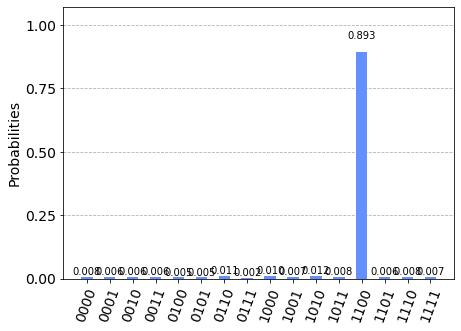

In [34]:
simulator = Aer.get_backend('aer_simulator_matrix_product_state')
#simulator = Aer.get_backend('aer_simulator_extended_stabilizer')
#simulator = Aer.get_backend('aer_simulator_stabilizer')
#result = execute(qc, backend=simulator, shots=1024).result()
t_qc = transpile(qc, simulator)
qobj = assemble(t_qc, shots=1000)
result = simulator.run(qobj).result()

plot_histogram(result.get_counts())